gen	nevals	avg  	min	max
0  	0     	1.826	0  	8  
1  	393   	2.834	0  	9  
2  	405   	3.572	0  	11 
3  	388   	4.134	0  	13 
4  	402   	4.766	0  	13 
5  	411   	5.502	0  	15 
6  	385   	6.02 	0  	16 
7  	388   	7.04 	0  	17 
8  	381   	7.82 	0  	17 
9  	387   	8.864	0  	21 
10 	389   	9.756	0  	21 
11 	378   	10.162	0  	22 
12 	397   	11.448	0  	23 
13 	405   	11.828	0  	23 
14 	388   	13.29 	0  	25 
15 	391   	13.458	0  	28 
16 	387   	14.624	0  	29 
17 	403   	15.566	0  	30 
18 	393   	16.256	0  	30 
19 	379   	16.846	0  	32 
20 	404   	17.652	0  	30 
21 	412   	18.316	0  	34 
22 	405   	19.666	0  	34 
23 	390   	20.278	0  	35 
24 	400   	21.162	0  	36 
25 	395   	21.206	0  	38 
26 	389   	22.832	0  	38 
27 	410   	21.97 	0  	38 
28 	397   	22.89 	0  	38 
29 	412   	24.158	0  	38 
30 	398   	25.384	0  	38 
31 	384   	25.216	0  	38 
32 	389   	25.38 	0  	38 
33 	396   	26.134	0  	38 
34 	405   	26.796	0  	38 
35 	396   	26.92 	0  	38 
36 	397   	28.43 	0  	38 
37 	384   	28.296	0  	38

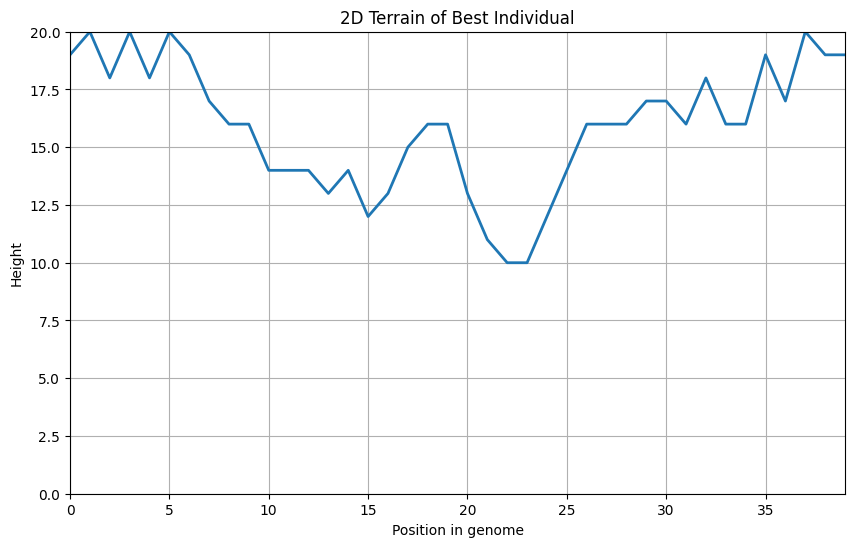

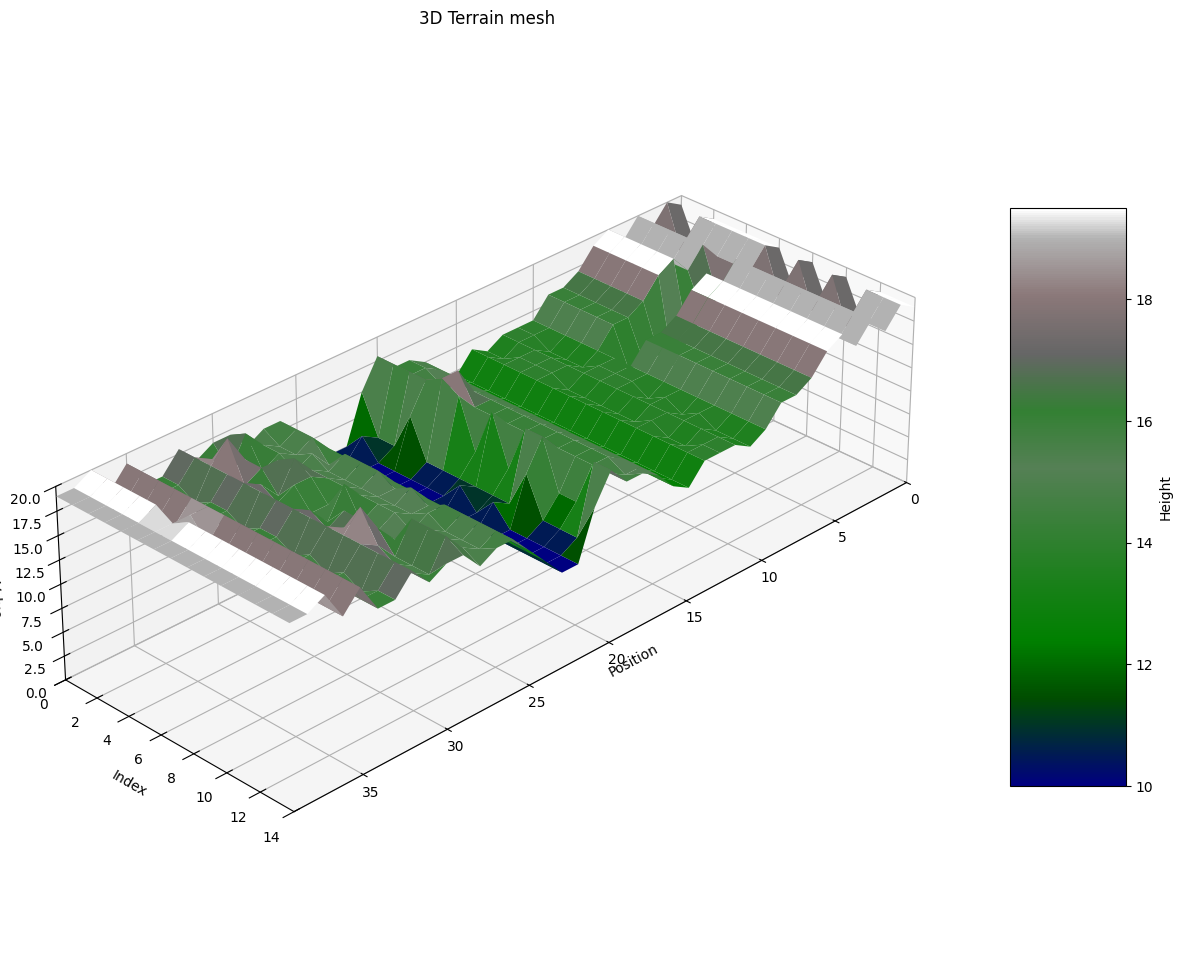

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deap import base, creator, tools, algorithms
from matplotlib.colors import LinearSegmentedColormap

# ----------------------------------------------------------
# terrain configuration
GENOME_LENGTH = 40          # length of the terrain genome
MIN_HEIGHT = 0             # minimum height value
MAX_HEIGHT = 20            # maximum height value

# ----------------------------------------------------------
# genetic algorithm parameters
POPULATION_SIZE = 500      # number of individuals in population
MUTATION_RATE = 0.9        # probability of mutation
CROSSOVER_RATE = 0.7      # probability of crossover
TOURNAMENT_SIZE = 3        # size of tournament selection
ELITISM_SIZE = 15          # number of best individuals to keep
EVALUATION_DIFFERENCE = 1.2 # range factor for fitness evaluation
MAX_GENERATIONS = 200      # number of generations to run
# ----------------------------------------------------------

# clear existing deap classes to avoid conflicts
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# create deap fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def sophisticated_fitness_function(individual):
    # evaluate terrain smoothness by checking neighbor height differences
    score = 0
    variable = EVALUATION_DIFFERENCE
    genome = individual
    
    # check first element's next neighbor
    if (genome[1] >= genome[0] / variable and 
        genome[1] <= genome[0] * variable):
        score += 1
    
    # check middle elements' previous and next neighbors
    for i in range(1, len(genome) - 1):
        if (genome[i - 1] >= genome[i] / variable and 
            genome[i - 1] <= genome[i] * variable and 
            genome[i + 1] >= genome[i] / variable and 
            genome[i + 1] <= genome[i] * variable):
            score += 1
    
    # check last element's previous neighbor
    if (genome[-2] >= genome[-1] / variable and 
        genome[-2] <= genome[-1] * variable):
        score += 1
    
    return score,

# initialize deap toolbox
toolbox = base.Toolbox()

# register functions for generating genes, individuals, and population
toolbox.register("gene_maker", random.randint, MIN_HEIGHT, MAX_HEIGHT)
toolbox.register("individual_creator", tools.initRepeat, creator.Individual, 
                 toolbox.gene_maker, n=GENOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual_creator)

# register genetic algorithm operators
toolbox.register("evaluate", sophisticated_fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_HEIGHT, up=MAX_HEIGHT, 
                 indpb=CROSSOVER_RATE)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
toolbox.register("elitism", tools.selBest, k=ELITISM_SIZE)

# initialize statistics tracking
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # track average fitness
stats.register("min", np.min)   # track minimum fitness
stats.register("max", np.max)   # track maximum fitness

if __name__ == "__main__":
    # create initial population
    population = toolbox.population(n=POPULATION_SIZE)
    
    # evaluate fitness for all individuals
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # create hall of fame to store top individuals
    hof = tools.HallOfFame(ELITISM_SIZE)
    
    # run genetic algorithm
    algorithms.eaSimple(population, 
                        toolbox,
                        cxpb=CROSSOVER_RATE,
                        mutpb=MUTATION_RATE,
                        ngen=MAX_GENERATIONS,
                        stats=stats,
                        halloffame=hof,
                        verbose=True)
    
    # extract best individual from population
    best_individual = tools.selBest(population, 1)[0]

    # print results
    # print("hall of fame:", hof)
    print("best individual:", best_individual)
    print("fitness value:", best_individual.fitness.values[0])
    
    # define custom colormap for terrain heights
    colors = [
        (0.0, (0.0, 0.0, 0.5)),         # 0% - dark blue
        (0.15, (0.0, 0.3, 0.0)),        # 15% - dark green
        (0.25, (0.0, 0.5, 0.0)),        # 25% - green
        (0.35, (0.1, 0.5, 0.1)),        # 35% - light green
        (0.55, (0.333, 0.5, 0.333)),    # 55% - greenish gray
        (0.65, (0.2, 0.5, 0.2)),        # 65% - medium green
        (0.75, (0.4, 0.4, 0.4)),        # 75% - gray
        (0.85, (0.545, 0.471, 0.475)),  # 85% - brownish gray
        (0.95, (0.7, 0.7, 0.7)),        # 95% - light gray
        (1.0, (1.0, 1.0, 1.0))          # 100% - white
    ]
    cmap = LinearSegmentedColormap.from_list('terrain_cmap', [(p, c) for p, c in colors])

    # create 2d plot for best individual
    fig_2d = plt.figure(figsize=(10, 6))
    ax_2d = fig_2d.add_subplot(111)
    
    # prepare data for 2d line plot
    x = np.arange(GENOME_LENGTH)
    y = np.array(best_individual)
    
    # plot line with default color
    ax_2d.plot(x, y, linewidth=2)
    
    # set labels and title
    ax_2d.set_xlabel('Position in genome')
    ax_2d.set_ylabel('Height')
    ax_2d.set_title('2D Terrain of Best Individual')
    
    # set axis limits
    ax_2d.set_xlim(0, GENOME_LENGTH - 1)
    ax_2d.set_ylim(MIN_HEIGHT, MAX_HEIGHT)
    
    # add grid for better readability
    ax_2d.grid(True)
    
    # create 3d plot
    fig_3d = plt.figure(figsize=(15, 15))
    ax_3d = fig_3d.add_subplot(111, projection='3d')  # single 3d subplot (1x1 grid)

    # prepare data for surface plot
    x_3d = np.arange(GENOME_LENGTH)
    y_3d = np.arange(ELITISM_SIZE)
    X, Y = np.meshgrid(x_3d, y_3d)
    Z = np.array([hof[i] for i in range(ELITISM_SIZE)])

    # plot surface with height-based colormap
    surf = ax_3d.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')

    # set axis labels and title
    ax_3d.set_xlabel('Position')
    ax_3d.set_ylabel('Index')
    ax_3d.set_zlabel('Value')
    ax_3d.set_title('3D Terrain mesh')

    # set axis limits
    ax_3d.set_xlim(0, GENOME_LENGTH - 1)
    ax_3d.set_ylim(0, ELITISM_SIZE - 1)
    ax_3d.set_zlim(MIN_HEIGHT, MAX_HEIGHT)

    # balance plot proportions
    ax_3d.set_box_aspect((GENOME_LENGTH, ELITISM_SIZE, MAX_HEIGHT * 0.5))

    # set view angle for better perspective
    ax_3d.view_init(elev=30, azim=45)

    # add colorbar for height
    fig_3d.colorbar(surf, ax=ax_3d, label='Height', shrink=0.5, aspect=5)

    # display both plots
    plt.show()